# ROB2004 Final Project - pick and place objects

Frank Panda Robot:

<div>
<img src="./panda.jpg" width="200"/>
</div>

# Problem

Implement controller(s) using the code skeletong below to get the robot to build a tower of 3 cubes, with the green cube on the bottom and the blue cube on the top. 

<div>
<img src="./manipulation_scene.jpg" width="400"/>
</div>

You are free to use the methods that you want to solve the task, with the following constraints:
* You cannot use any external library apart from numpy and scipy
* You need to use at least one controller in the end-effector space
* You need to use at least one inverse geometry method
* You need to compensate for the gravity of the robot

In your report, describe the controller(s) and justify your choices. Analyze the behavior of the system (include plots of the end-effector trajectories, velocities, joint trajectories, etc as you see fit).

## Scene details
The position of the red cube in the spatial frame is $(0.35,0.58,0.65)$, the green cube is at $(0.2,0.58,0.65)$ and the blue cube at $(0.0,0.58,0.65)$.


In [1]:
# External Libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from panda import Simulator, PandaRobot

np.set_printoptions(precision=4, suppress = True)

pybullet build time: Mar 14 2024 13:49:57


**Helper Functions**

In [2]:
import scipy.optimize


class Task:
    
    def __init__(self, type, goal=None, P=50, D=50, max_error=0.01, update_text=None, holding=0):
        self.type = type
        self.goal = goal
        self.P = P
        self.D = D
        self.max_error = max_error
        self.update_text = update_text
        self.holding = holding
        self.q_goal = None
        
def robot_to_world_pose(pose):
    Twr = np.block([
    [np.identity(3), np.array([[0.0],[0.0],[0.5]])],
    [0.0,0.0,0.0,1.0]
    ])
    return Twr @ pose


def world_to_robot_pose(pose):
    Trw = np.block([
    [np.identity(3), np.array([[0.0],[0.0],[-0.5]])],
    [0.0,0.0,0.0,1.0]
    ])
    return Trw @ pose

def inverse_rotation(matrix):
    inverted_rotation = np.transpose(matrix)
    return inverted_rotation

def apply_rotation (rotation, position):
    return rotation @ position

def inverse_homogeneous_matrix(matrix):
    rotated_matrix = matrix[:3, :3]
    position = matrix[:3, 3].reshape(-1, 1)
    inverse_rotation_matrix = inverse_rotation(rotated_matrix)
    new_position = -1 * apply_rotation(inverse_rotation_matrix, position)
    inverted_homogeneous_matrix = np.block([[inverse_rotation_matrix, new_position], [0, 0, 0, 1]])
    return inverted_homogeneous_matrix

def from_skew_3d(matrix):
        return np.array([matrix[2][1], matrix[0][2], matrix[1][0]])

def to_twist_vector(linear_velocity, angular_velocity):
    return np.block([[angular_velocity,linear_velocity]]).T

def from_skew_6d(matrix):
    skew_w = matrix[0:3,0:3]
    w = from_skew_3d(skew_w)
    v = matrix[0:3,3]
    return to_twist_vector(v,w)

def transformation_to_twist(transformation):
        skew_twist = scipy.linalg.logm(transformation)
        twist = from_skew_6d(skew_twist)
        return twist

def pose_error_function(q, desired_pose, robot):

    measured_pos = robot.FK(q)
    delta_poses = np.linalg.inv(measured_pos) @ desired_pose
    pose_error = transformation_to_twist(delta_poses).squeeze()
    error = np.linalg.norm(pose_error)
    
    return error

def inverse_geometry(desired_pose, robot, current_q):
    
    # Perform minimization to find optimal joint configuration
    result = scipy.optimize.minimize(pose_error_function, np.array(current_q), args=(desired_pose, robot), bounds=joint_limits)
    
    # Return optimized joint configuration
    return result.x

# Example joint limits (replace with actual limits)
joint_limits = [
    (-2.8973, 2.8973),
    (-1.7628, 1.7628),
    (-2.8973, 2.8973),  
    (-3.0718, -0.0698),
    (-2.8973, 2.8973),
    (-0.0175, 3.7525),
    (-2.8973, 2.8973),
]


In [3]:
tasks = [
    # Assembling Blocks using Pose Control
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.35],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.82],[0.0, 0.0, 0.0, 1.0]]),update_text="Picking Red Block"),
    Task("grasp","open"),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.35],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.77],[0.0, 0.0, 0.0, 1.0]])),
    Task("grasp","close"),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.35],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.90],[0.0, 0.0, 0.0, 1.0]]),holding=1,update_text="Placing Red Block"),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.90],[0.0, 0.0, 0.0, 1.0]]),holding=1),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.85],[0.0, 0.0, 0.0, 1.0]]),holding=1),
    Task("grasp","open"),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.90],[0.0, 0.0, 0.0, 1.0]]),update_text="Picking Blue Block"),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.0],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.90],[0.0, 0.0, 0.0, 1.0]])),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.0],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.77],[0.0, 0.0, 0.0, 1.0]])),
    Task("grasp","close"),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.0],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.95],[0.0, 0.0, 0.0, 1.0]]),holding=1,update_text="Placing Blue Block"),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.95],[0.0, 0.0, 0.0, 1.0]]),holding=1),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 0.90],[0.0, 0.0, 0.0, 1.0]]),holding=1),
    Task("grasp","open"),
    Task("pose-control",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 1.1],[0.0, 0.0, 0.0, 1.0]]),update_text="Going to initial pose"),
    # Disassembling Blocks using Inverse Geometry
    Task("inverse-geometry",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.56],[0.0, 0.0, -1.0, 0.87],[0.0, 0.0, 0.0, 1.0]]),update_text="Removing Blue Block"),
    Task("grasp","close"),
    Task("inverse-geometry",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.57],[0.0, 0.0, -1.0, 1.0],[0.0, 0.0, 0.0, 1.0]]),holding=1),
    Task("inverse-geometry",np.array([[-1.0, 0.0, 0.0, 0.0],[0.0, 1.0, 0.0, 0.57], [0.0, 0.0, -1.0, 1.0],[0.0, 0.0, 0.0, 1.0]]),holding=1),
    Task("grasp","open"),
    Task("inverse-geometry",np.array([[-1.0, 0.0, 0.0, 0.21],[0.0, 1.0, 0.0, 0.57],[0.0, 0.0, -1.0, 0.81],[0.0, 0.0, 0.0, 1.0]]),update_text="Removing Blue Block"),
    Task("grasp","close"),
    Task("inverse-geometry",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.57],[0.0, 0.0, -1.0, 0.9],[0.0, 0.0, 0.0, 1.0]]),holding=1),
    Task("inverse-geometry",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.8],[0.0, 0.0, -1.0, 0.9],[0.0, 0.0, 0.0, 1.0]]),holding=1),
    Task("grasp","open"),
   Task("inverse-geometry",np.array([[-1.0, 0.0, 0.0, 0.2],[0.0, 1.0, 0.0, 0.58],[0.0, 0.0, -1.0, 1.1],[0.0, 0.0, 0.0, 1.0]]),update_text="Done! Going to initial pose"),
]

In [4]:
# Creating robot object and simulation

simulator = Simulator()
simulator.reset_state([0.,0,0.0,-np.pi/2.,0.,np.pi/2.,0.0])
my_robot = PandaRobot()

# Configs
run_time = 30.
dt = 0.0001
num_steps = int(run_time/dt)
ndofs = 7
time = np.zeros([num_steps])

# Task Initialization
task_index = 0
print("Update: ", tasks[0].update_text)

# Logging
q_p_logs = []
q_v_logs = []
eef_p_logs = []
eef_v_logs = []
eef_w_logs = []

# Control Loop
for i in range(num_steps):
    # Getting the current time
    time[i] = dt * i
    if task_index >= len(tasks):
        break
    task = tasks[task_index]

    # Getting the current joint positions/velocities
    q, dq = simulator.get_state()

    match task.type:

        case"pose-control":

            # EEF Jacobian in Body Space
            J = my_robot.get_jacobian(q, 'B')

            # Task Information
            desired_pose_world =  task.goal
            desired_pose = world_to_robot_pose(desired_pose_world)
            P = task.P*np.identity(6)
            D = task.D*np.identity(6)

            # Measured EEF Pose/Twist
            measured_pose = my_robot.FK(q)
            measured_twist = J@dq
            
            # Computed Pose Error (as twist)                 
            delta_poses = inverse_homogeneous_matrix(measured_pose) @ desired_pose
            pose_error = transformation_to_twist(delta_poses).squeeze()
            
            # Computed Twist Error        
            reference_twist = np.zeros(6)
            twist_error = reference_twist - measured_twist

            # Positional Error to Stop Changing
            if np.all(abs(pose_error) < task.max_error):
                task_index = task_index + 1
                if task_index<len(tasks) and  tasks[task_index].update_text != None:
                    print("Update: ", tasks[task_index].update_text)
                q_p_logs.append(q)
                q_v_logs.append(dq)
                eef_p_logs.append(robot_to_world_pose(my_robot.FK(q))[0:3,3])
                eef_v_logs.append((my_robot.get_jacobian(q,'B')@dq)[3:6])
                eef_w_logs.append((my_robot.get_jacobian(q,'B')@dq)[0:3])
                continue

            # Impedence Control
            joint_torques = J.T @ ( P @ pose_error + D@ twist_error) + my_robot.g(q)
            joint_torques -= J.T @ np.array([0.0,0.0,0.0,0.0,0.0,0.981*task.holding])

            simulator.send_joint_torque(joint_torques)

        case"inverse-geometry":

            # Task Information
            desired_pose = world_to_robot_pose(task.goal)
            P = task.P
            D = task.D

            # Compute Inverse Geometry (if not calculated yet)
            if np.any(task.q_goal) == None:
                task.q_goal = inverse_geometry(desired_pose,my_robot,q)
                tasks[task_index] = task
            # Positional Error to Stop Changing
            if np.all(abs(q-task.q_goal) < 0.06):
                task_index = task_index + 1
                if task_index<len(tasks) and  tasks[task_index].update_text != None:
                    print("Update: ", tasks[task_index].update_text)
                q_p_logs.append(q)
                q_v_logs.append(dq)
                eef_p_logs.append(robot_to_world_pose(my_robot.FK(q))[0:3,3])
                eef_v_logs.append((my_robot.get_jacobian(q,'B')@dq)[3:6])
                eef_w_logs.append((my_robot.get_jacobian(q,'B')@dq)[0:3])
                continue

            joint_torques = ( P * (task.q_goal-q) + D * (np.zeros(7)-dq)) + my_robot.g(q)
            J = my_robot.get_jacobian(q, 'B')
            joint_torques -= J.T @ np.array([0.0,0.0,0.0,0.0,0.0,0.981*task.holding])

            simulator.send_joint_torque(joint_torques.T)

        
        case "grasp":

            if task.goal=="open":
                simulator.gripper_move([0.04,0.04])
            elif task.goal=="close":
                simulator.gripper_move([0.0,0.0])

            task_index = task_index + 1
            if task_index<len(tasks) and tasks[task_index].update_text != None:
                    print("Update: ", tasks[task_index].update_text)
    
    # Logging the eef/joints positions/velocities
    q_p_logs.append(q)
    q_v_logs.append(dq)
    eef_p_logs.append(robot_to_world_pose(my_robot.FK(q))[0:3,3])
    eef_v_logs.append((my_robot.get_jacobian(q,'B')@dq)[3:6])
    eef_w_logs.append((my_robot.get_jacobian(q,'B')@dq)[0:3])
    # Stepping the simulator
    simulator.step()

Version = 4.1 Metal - 88
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
Update:  Picking Red Block


2024-05-10 17:42:48.583 Python[61457:4510745] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Update:  Placing Red Block
Update:  Picking Blue Block
Update:  Placing Blue Block
Update:  Going to initial pose
Update:  Removing Blue Block
Update:  Removing Blue Block
Update:  Done! Going to initial pose


**Plotting the Joints Positions/Velocities**

In [5]:
q_p_logs = np.array(q_p_logs)
q_v_logs = np.array(q_v_logs)
eef_p_logs = np.array(eef_p_logs)
eef_v_logs = np.array(eef_v_logs)
eef_w_logs = np.array(eef_w_logs)

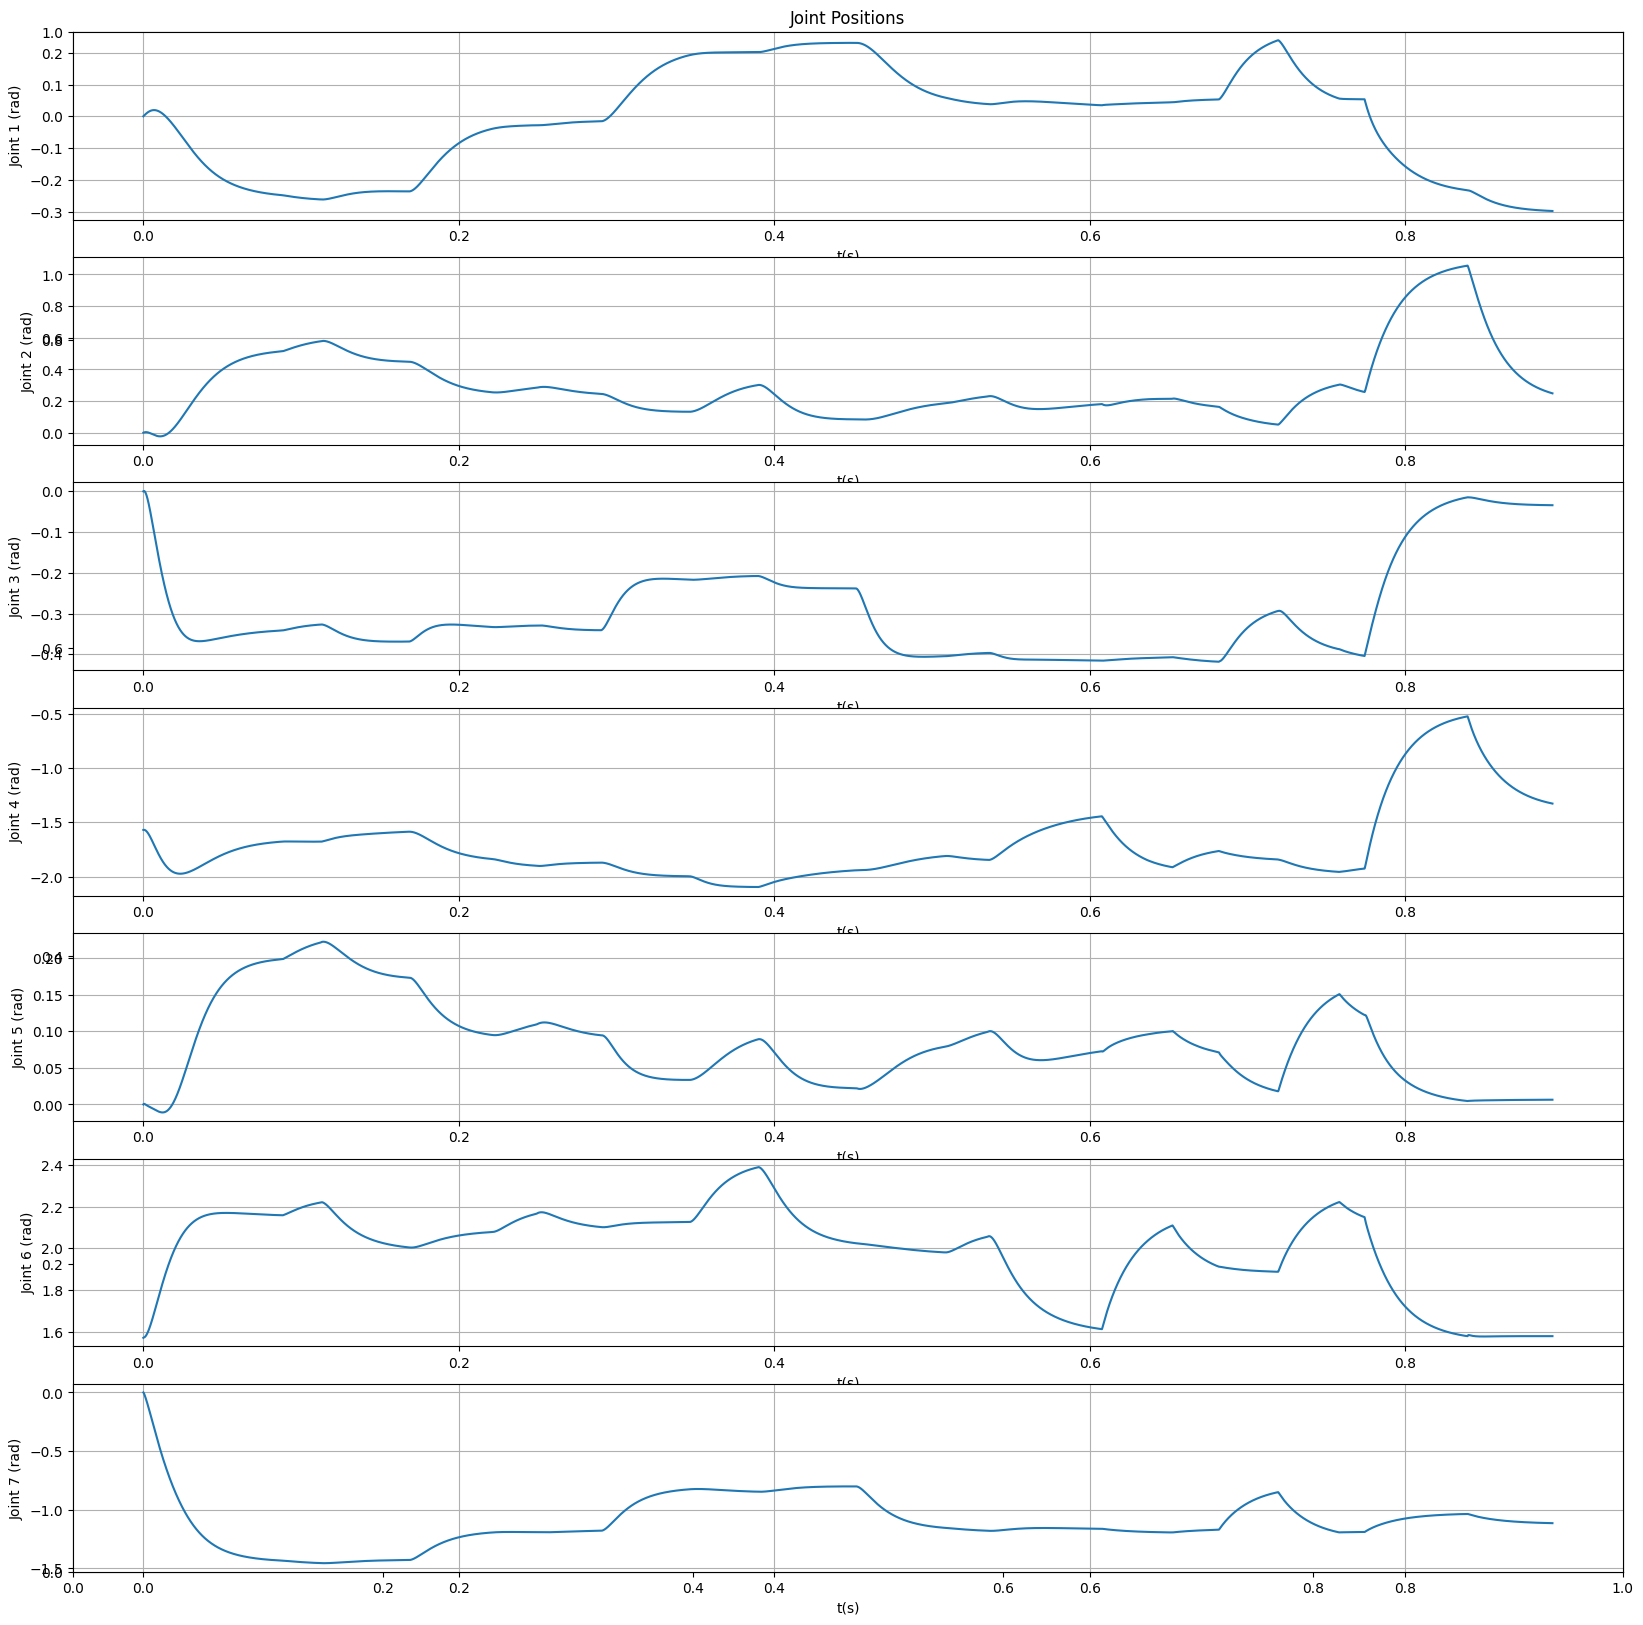

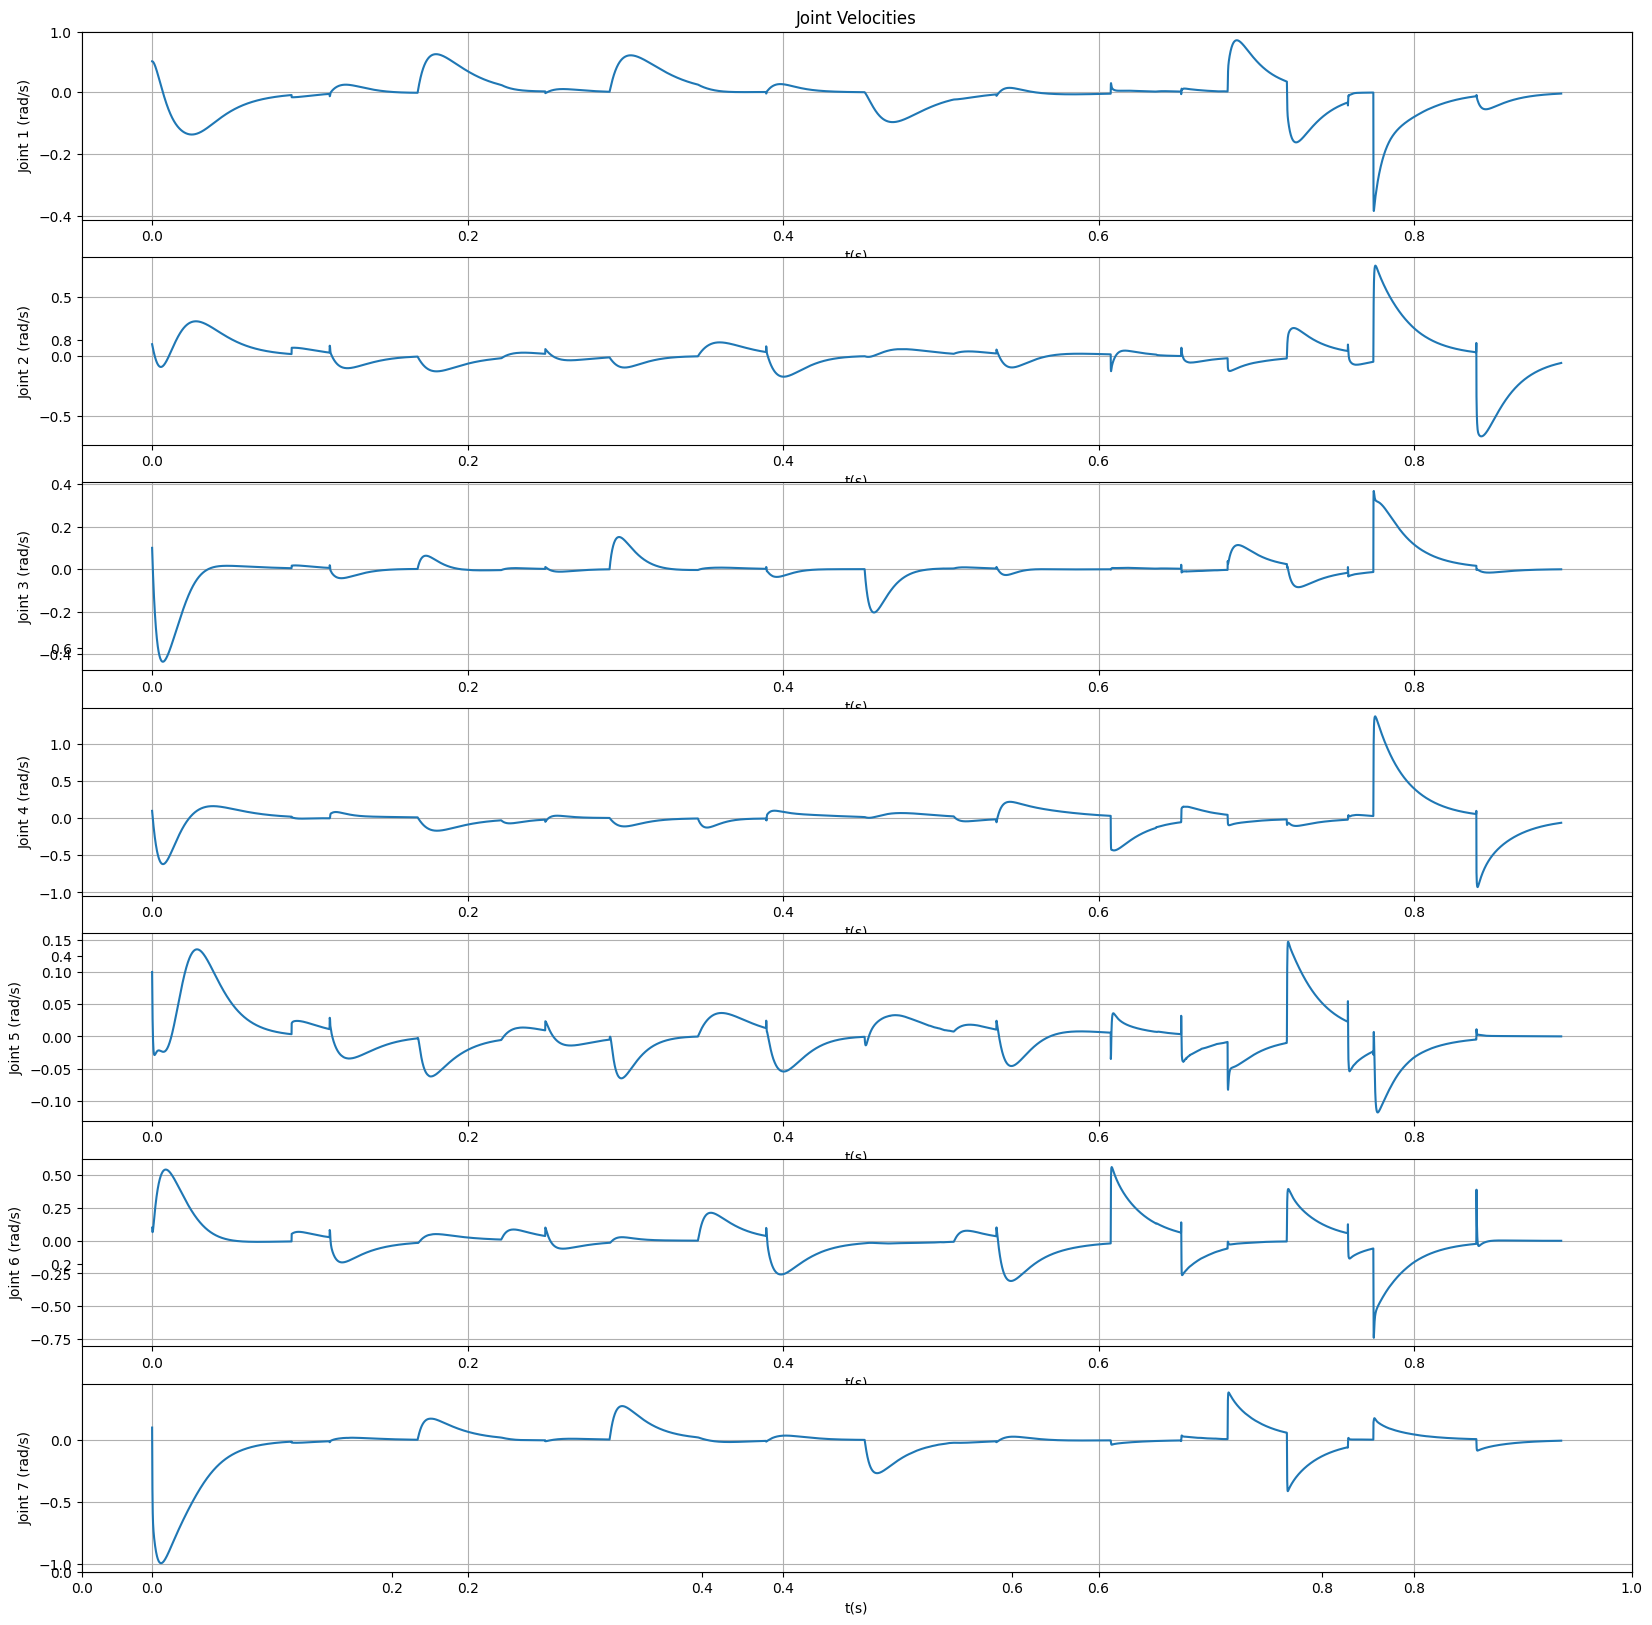

In [6]:
plt.figure(figsize=(20,20))
plt.title("Joint Positions")
for i in range(ndofs):
    plt.subplot(ndofs,1,i+1)
    plt.plot(time[0:q_p_logs[:,i].shape[0]],q_p_logs[:,i])
    plt.xlabel("t(s)")
    plt.ylabel("Joint " + str(i+1) + " (rad)")
    plt.grid(True)

plt.figure(figsize=(20,20))
plt.title("Joint Velocities")
for i in range(ndofs):
    plt.subplot(ndofs,1,i+1)
    plt.plot(time[0:q_v_logs[:,i].shape[0]],q_v_logs[:,i])
    plt.xlabel("t(s)")
    plt.ylabel("Joint " + str(i+1) + " (rad/s)")
    plt.grid(True)


**Plotting End-Effector Positions/Velocities**

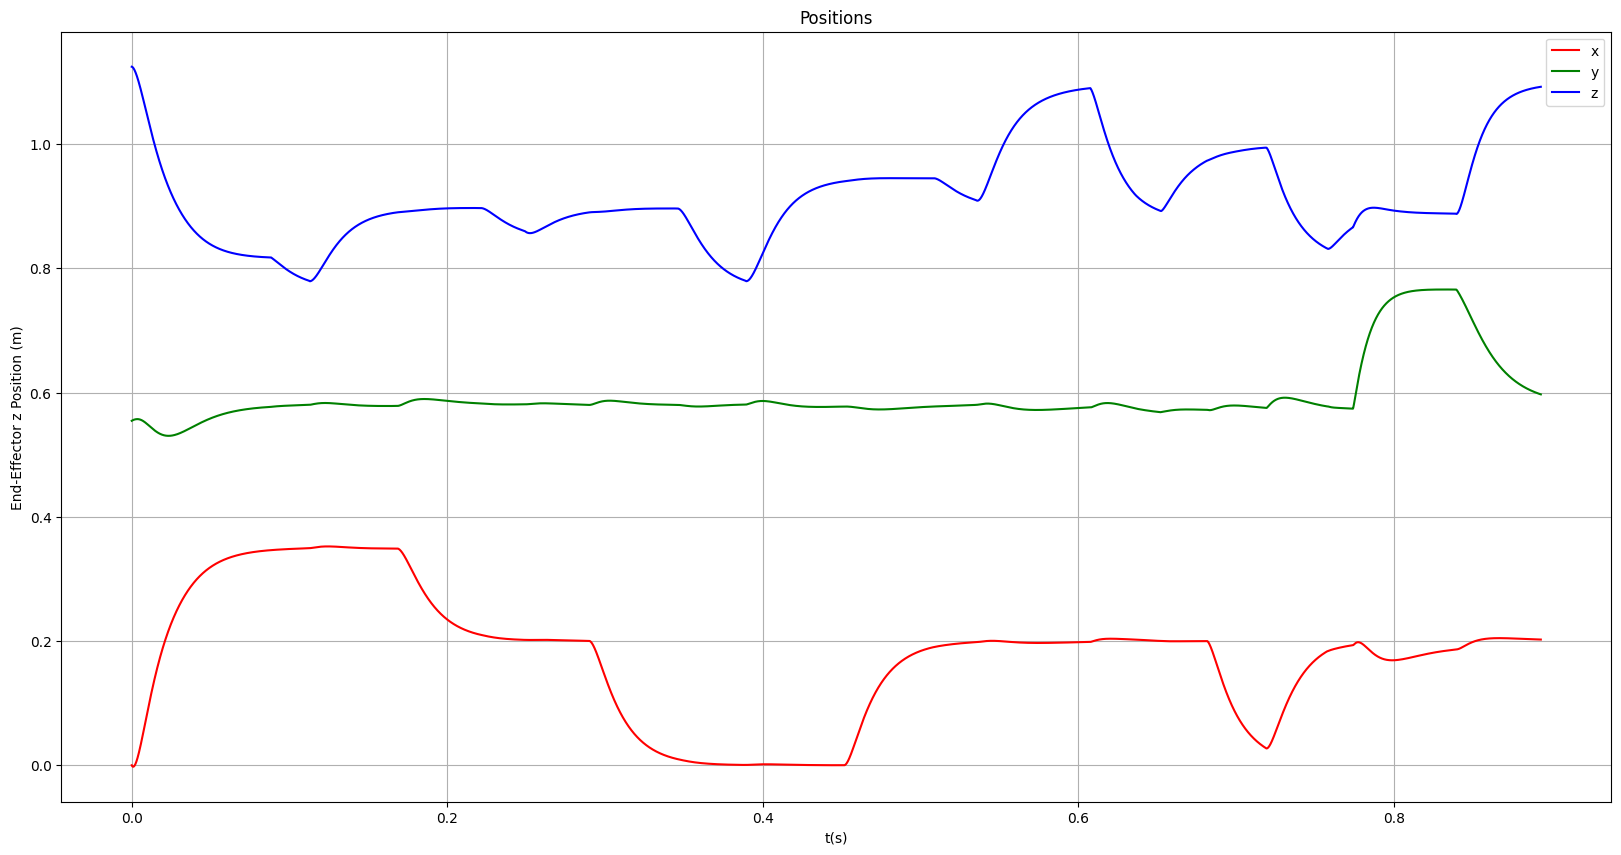

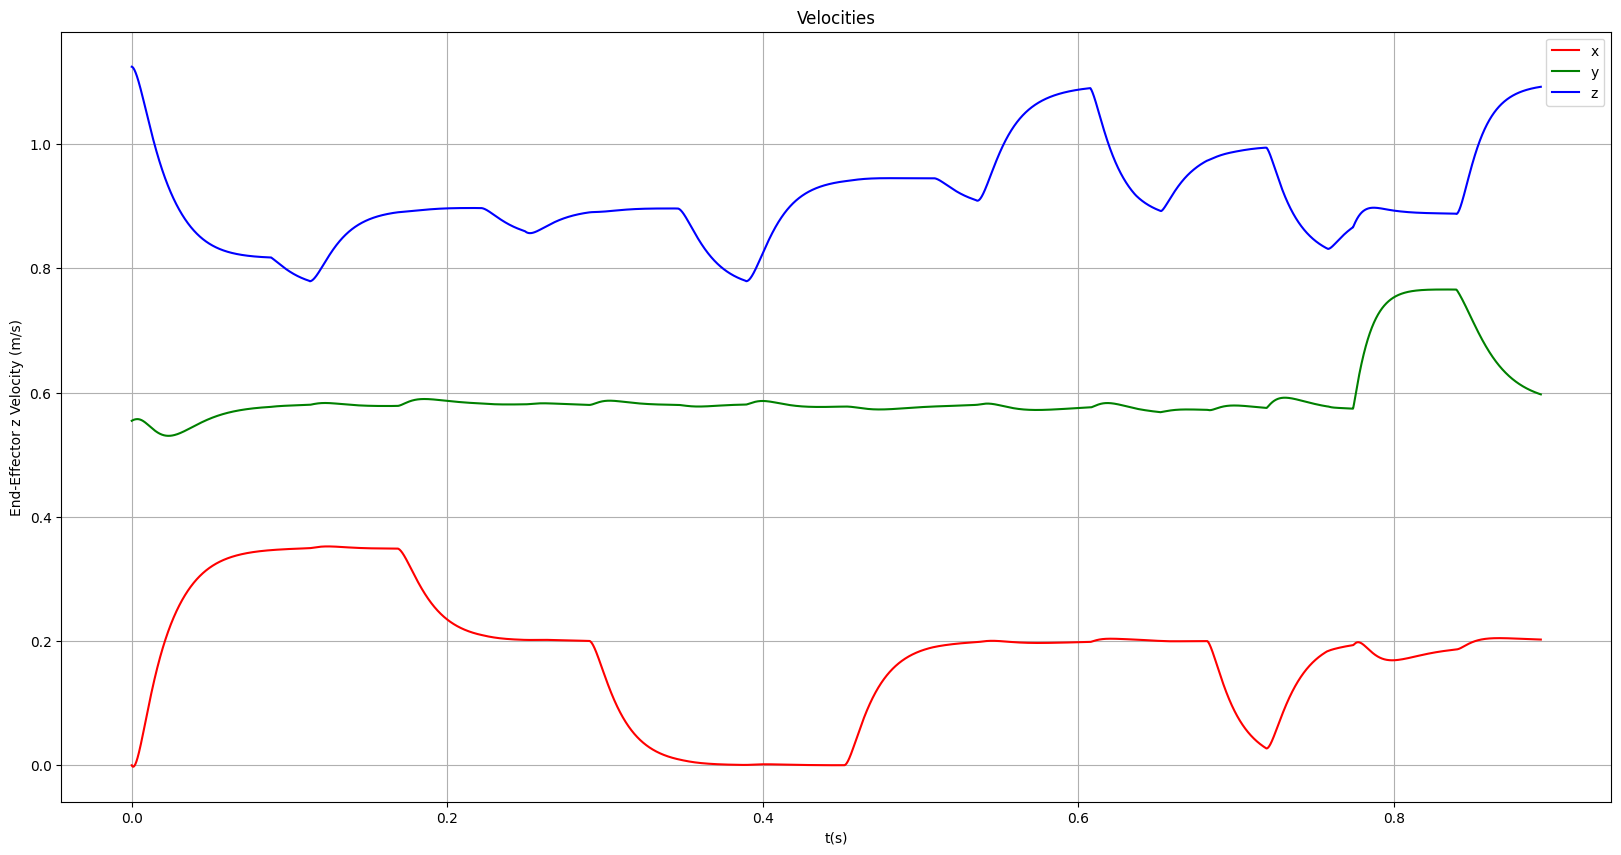

In [7]:
plt.figure(figsize=(20,10))
plt.title("Positions")
labels = ["x","y","z"]
colors = ["r","g","b"]
for i in range(3):
    plt.plot(time[0:eef_p_logs[:,i].shape[0]],eef_p_logs[:,i],colors[i])
    plt.xlabel("t(s)")
    plt.ylabel("End-Effector " + labels[i] + " Position (m)")
    plt.legend(labels)
    plt.grid(True)

plt.figure(figsize=(20,10))
plt.title("Velocities")
labels = ["x","y","z"]
colors = ["r","g","b"]
for i in range(3):
    plt.plot(time[0:eef_p_logs[:,i].shape[0]],eef_p_logs[:,i],colors[i])
    plt.xlabel("t(s)")
    plt.ylabel("End-Effector " + labels[i] + " Velocity (m/s)")
    plt.legend(labels)
    plt.grid(True)




**Plotting 3D Tasks Trajectory**

/var/folders/y_/g46v5wcs2mlg96p8tytg8l7m0000gn/T/ipykernel_61457/1639675872.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(eef_p_logs[:,0], eef_p_logs[:,1], eef_p_logs[:,2], cmap='viridis')


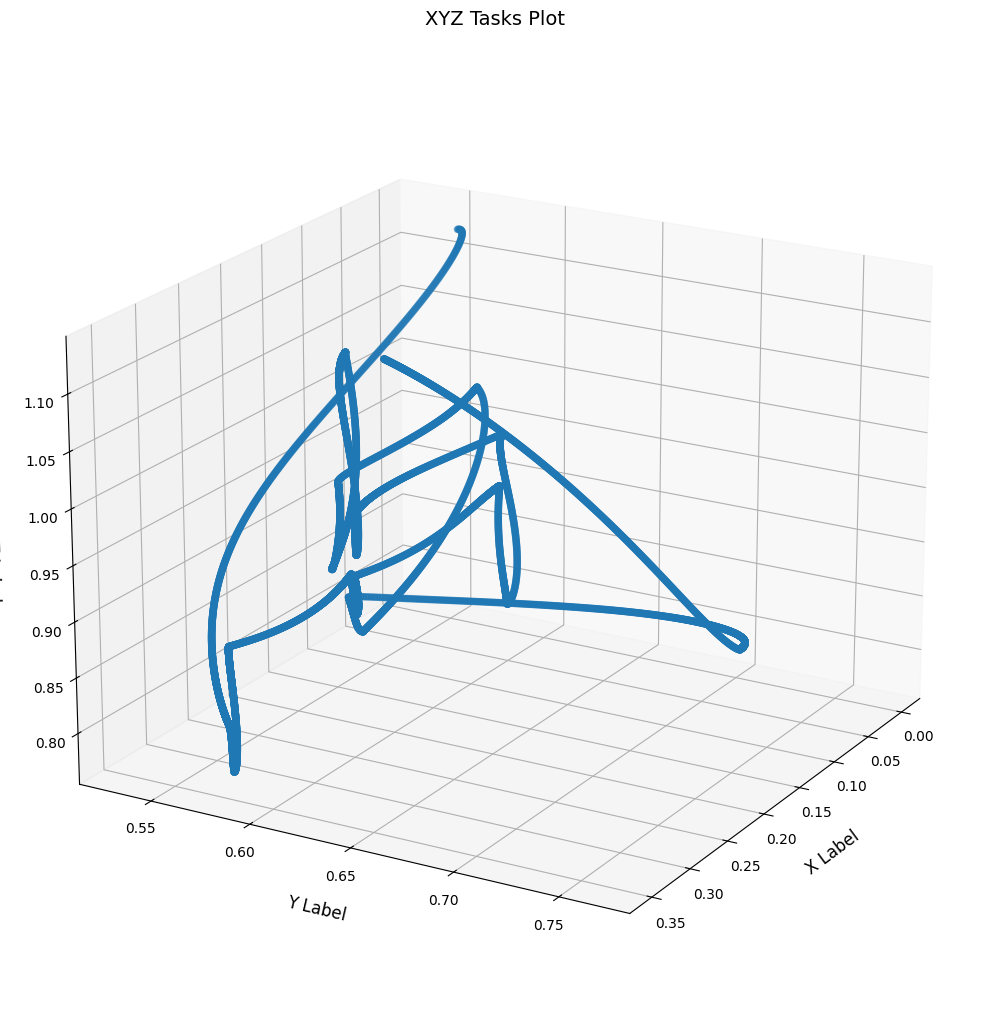

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(eef_p_logs[:,0], eef_p_logs[:,1], eef_p_logs[:,2], cmap='viridis')

ax.set_xlabel('X Label', fontsize=12, labelpad=12)
ax.set_ylabel('Y Label', fontsize=12, labelpad=12)
ax.set_zlabel('Z Label', fontsize=12, labelpad=12)
ax.set_title('XYZ Tasks Plot', fontsize=14, pad=20)
ax.grid(True, linestyle='---', alpha=0.5)
ax.view_init(elev=20, azim=30)

plt.tight_layout()
plt.show()